In [1]:
import pickle
from matplotlib import pyplot as plt
from scipy.stats import sem
import seaborn as sns
import numpy as np

DATASET= 'weibo'
if DATASET == 'twitter': ext = -3; idx = 17
else: ext = -4; idx = 16

iter = 50

In [2]:
sns.set_style("ticks",{'axes.grid': False})
sns.set_context("paper", font_scale=4, rc={"lines.linewidth": 3,
                                           'lines.markersize': 18})

colors = ["windows blue", "amber"]
# colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
color1, color2 = sns.xkcd_palette(colors)


In [3]:
alpha = 100


In [4]:
q_file_optimal = pickle.load(open('./../%s/results/q_file_Optimal_alpha_%d.pkl' %(DATASET, alpha) , 'rb'))
q_file_oracle = pickle.load(open('./../%s/results/q_file_Oracle_alpha_%d.pkl' %(DATASET, alpha) , 'rb'))
q_file_flagratio = pickle.load(open('./../%s/results/q_file_Flagratio_alpha_%d.pkl' %(DATASET, alpha) , 'rb'))
q_file_baseline = pickle.load(open('./../%s/results/q_file_Baseline_alpha_%d.pkl' %(DATASET, alpha) , 'rb'))
q_file_threshold = pickle.load(open('./../%s/results/q_file_Threshold_alpha_%d.pkl' %(DATASET, alpha) , 'rb'))

In [5]:
target_files = pickle.load(open('./../%s/results/target_files.pkl' %(DATASET) , 'rb'))
file_data = dict()
for file in target_files:
    file_pkl = file[:ext] + 'pkl'
    data = pickle.loads(open('./../%s/exposure_data/' %(DATASET) + file_pkl, 'rb').read())
    file_data[file_pkl] = data

In [6]:
def num_factcheck(q_file, str_idx, end_idx, file_data=file_data):
    returnthis = []
    for vv in range(str_idx, end_idx):
        taus_long = q_file[pow(10, vv)]
        files = list(taus_long.keys())
        tmp_big = []
        for file in files:
            file_pkl = file[:ext] + 'pkl'
            T = file_data[file_pkl][-1, 1]
            tmp = taus_long[file]
            tmp = [1 if v != None else 0 for v in tmp]
            tmp_big.append(tmp)
        tmp_big = np.array(tmp_big)
        returnthis.append(np.mean(np.sum(tmp_big, axis=0)))
    return returnthis

In [7]:
def precision(q_file, str_idx, end_idx, file_data=file_data):
    precs_big = []
    precs_big_sem = []
    for vv in range(str_idx, end_idx):
        precs = []
        for i in range(iter):
            num = 0
            denom = 0
            for file, taus in q_file[pow(10, vv)].items():
                file_pkl = file[:ext] + 'pkl'
                T = file_data[file_pkl][-1, 1]
                if taus[i] != None:
                    if taus[i] < T:
                        denom += 1
                        if file[0] == 'R':
                            num += 1
            if denom != 0:
                precs.append(num / denom)
        precs_big.append(np.mean(precs))
        precs_big_sem.append(sem(precs))

    return (precs_big, precs_big_sem)


In [8]:
def misinfo_reduction(q_file, str_idx, end_idx, file_data=file_data):
    reducs_big = []
    reducs_big_sem = []
    for j in range(str_idx, end_idx):
        reducs = []
        for i in range(iter):
            total_events = 0
            reduced_events = 0
            for file in target_files:        
                if file[0] == 'R':
                    data = file_data[file[:ext] + 'pkl' ]
                    total_events += len(data)
                    times = data[:, 1]
                    times = times - np.min(times)
                    tau = q_file[pow(10, j)][file][i]
                    if tau == None:
                        tau = data[-1, 1]
                    reduced_events += len(times[times > tau])
            reducs.append(reduced_events / total_events)
        reducs_big.append(np.mean(reducs))
        reducs_big_sem.append(sem(reducs))

    return (reducs_big, reducs_big_sem)


In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12*1.5, 8))
ax1, ax2 = axs

In [10]:
ax1.errorbar(num_factcheck(q_file_oracle, 0, 10), precision(q_file_oracle, 0, 10)[0], yerr=precision(q_file_oracle, 0, 10)[1], color=color1, marker = '^', linestyle='--', label='Oracle', linewidth=4)
ax1.errorbar(num_factcheck(q_file_optimal, 0, 10), precision(q_file_optimal, 0, 10)[0], yerr=precision(q_file_optimal, 0, 10)[1], color=color1, marker = 'o', linestyle='-', label='Curb', linewidth=4)
ax1.errorbar(num_factcheck(q_file_flagratio, 5, idx), precision(q_file_flagratio, 5, idx)[0], yerr=precision(q_file_flagratio, 5, idx)[1], color='#666666', marker = 'D', linestyle='-.', label='Flag Ratio', ms =16)
ax1.errorbar(num_factcheck(q_file_threshold, 0, 10), precision(q_file_threshold, 0, 10)[0], yerr=precision(q_file_threshold, 0, 10)[1], color='#666666', marker = '|', linestyle='--', label='Flag Sum')
ax1.errorbar(num_factcheck(q_file_baseline, 0, 13), precision(q_file_baseline, 0, 13)[0], yerr=precision(q_file_baseline, 0, 13)[1], color='#666666', marker = '<', linestyle=':', label='Exposure', ms =16)

ax1.legend(loc='best', numpoints=1, fontsize=25)

sns.despine(ax=ax1, right=True, left=False)

ax1.set_xlabel('# Fact checks')
_ = ax1.set_ylabel('Precision')

In [11]:
ax2.errorbar(num_factcheck(q_file_oracle, 0, 10), misinfo_reduction(q_file_oracle, 0, 10)[0], yerr=misinfo_reduction(q_file_oracle, 0, 10)[1], color=color1, marker = '^', linestyle='--', label='Oracle', linewidth=4)
ax2.errorbar(num_factcheck(q_file_optimal, 0, 10), misinfo_reduction(q_file_optimal, 0, 10)[0], yerr=misinfo_reduction(q_file_optimal, 0, 10)[1], color=color1, marker = 'o', linestyle='-', label='Curb', linewidth=4)
ax2.errorbar(num_factcheck(q_file_flagratio, 5, idx), misinfo_reduction(q_file_flagratio, 5, idx)[0], yerr=misinfo_reduction(q_file_flagratio, 5, idx)[1], color='#666666', marker = 'D', linestyle='-.', label='Flag Ratio', ms =16)
ax2.errorbar(num_factcheck(q_file_threshold, 0, 10), misinfo_reduction(q_file_threshold, 0, 10)[0], yerr=misinfo_reduction(q_file_threshold, 0, 10)[1], color='#666666', marker = '|', linestyle='--', label='Flag Sum')
ax2.errorbar(num_factcheck(q_file_baseline, 0, 13), misinfo_reduction(q_file_baseline, 0, 13)[0], yerr=misinfo_reduction(q_file_baseline, 0, 13)[1], color='#666666', marker = '<', linestyle=':', label='Exposure', ms =16)


# ax2.legend(loc='best', numpoints=1)

sns.despine(ax=ax2, right=True, left=False)

ax2.set_xlabel('# Fact checks')
_ = ax2.set_ylabel('Reduction')

In [12]:
fig.tight_layout()

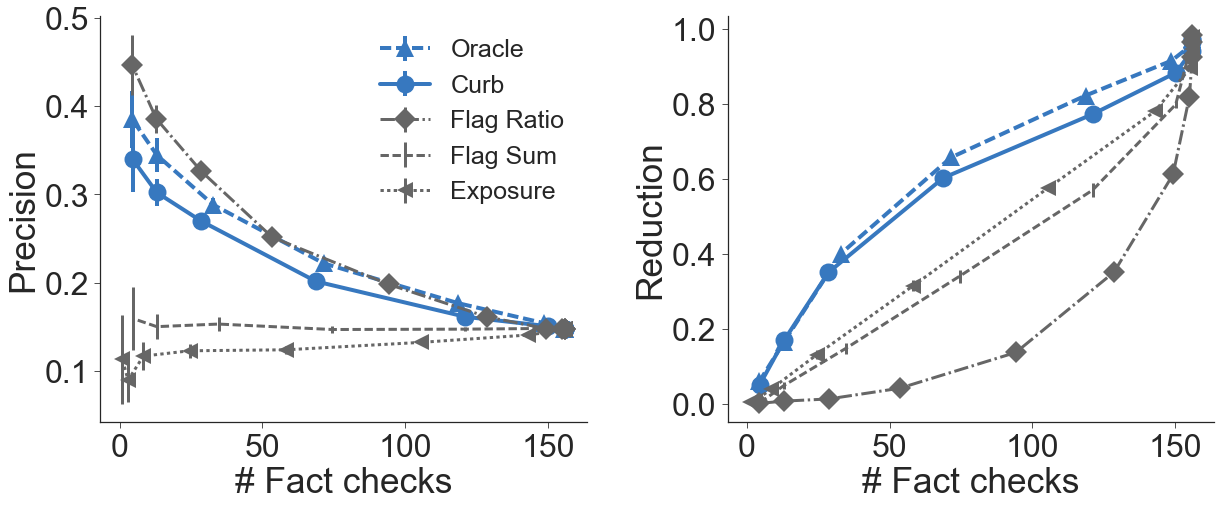

In [13]:
fig